In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
import matplotlib.cm as cm
import copy
import tempfile
import os

# PCA

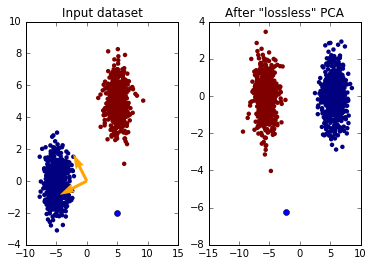

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA

X, y = make_blobs(n_samples=1000, random_state=101, centers=[[-5, 0], [5, 5]])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pca_comp = pca.components_.T

test_point = np.matrix([5, -2])
test_point_pca = pca.transform(test_point)

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='none')
plt.quiver(0, 0, pca_comp[:,0], pca_comp[:,1], width=0.02, scale=5, color='orange')
plt.plot(test_point[0, 0], test_point[0, 1], 'o')
plt.title('Input dataset')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='none')
plt.plot(test_point_pca[0, 0], test_point_pca[0, 1], 'o')
plt.title('After "lossless" PCA')

plt.show()



In [3]:
print "The blue point is in", test_point[0, :]
print "After the transformation is in", test_point_pca[0, :]
print "Since (X-MEAN) * PCA_MATRIX = ", np.dot(test_point - pca.mean_, pca_comp)



The blue point is in [[ 5 -2]]
After the transformation is in [-2.34969911 -6.2575445 ]
Since (X-MEAN) * PCA_MATRIX =  [[-2.34969911 -6.2575445 ]]


Iris dataset contains 4 features
After PCA, it contains 2 features
The variance is [% of original]: 0.977631775025


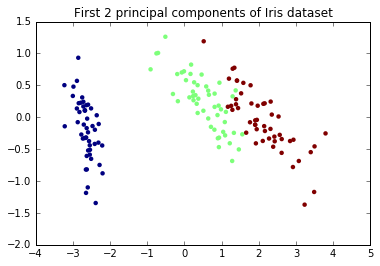

In [4]:
from sklearn import datasets


iris = datasets.load_iris()
X = iris.data
y = iris.target

print "Iris dataset contains", X.shape[1], "features"

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print "After PCA, it contains", X_pca.shape[1], "features"
print "The variance is [% of original]:", sum(pca.explained_variance_ratio_)


plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='none')
plt.title('First 2 principal components of Iris dataset')

plt.show()

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

def test_classification_accuracy(X_in, y_in):
    X_train, X_test, y_train, y_test = \
        train_test_split(X_in, y_in, random_state=101, train_size=0.50)

    clf = SGDClassifier('log', random_state=101)
    clf.fit(X_train, y_train)
    
    return accuracy_score(y_test, clf.predict(X_test))

print "SGDClassifier accuracy on Iris set:", \
            test_classification_accuracy(X, y)
print "SGDClassifier accuracy on Iris set after PCA (2 components):", \
            test_classification_accuracy(X_pca, y)

SGDClassifier accuracy on Iris set: 0.586666666667
SGDClassifier accuracy on Iris set after PCA (2 components): 0.72


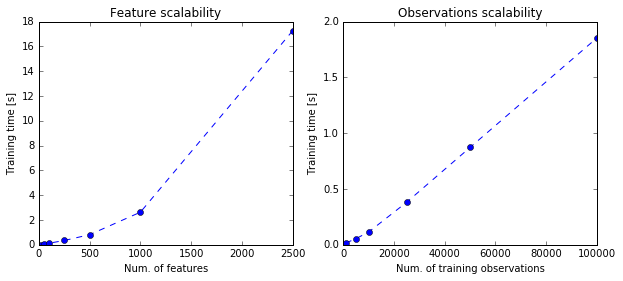

In [6]:
import time

def check_scalability(test_pca):
    pylab.rcParams['figure.figsize'] = (10, 4)
    
    # FEATURES
    n_points = 10000
    n_features = [20, 50, 100, 250, 500, 1000, 2500]
    time_results = []

    for n_feature in n_features:
        X, _ = make_blobs(n_points, n_features=n_feature, random_state=101)
        
        pca = copy.deepcopy(test_pca)
        tik = time.time()
        pca.fit(X)
        time_results.append(time.time()-tik)
    
    plt.subplot(1, 2, 1)
    plt.plot(n_features, time_results, 'o--')
    plt.title('Feature scalability')
    plt.xlabel('Num. of features')
    plt.ylabel('Training time [s]')
    
    # OBSERVATIONS
    n_features = 100
    n_observations = [1000, 5000, 10000, 25000, 50000, 100000]
    time_results = []

    for n_points in n_observations:
        X, _ = make_blobs(n_points, n_features=n_features, random_state=101)
        pca = copy.deepcopy(test_pca)
        tik = time.time()
        pca.fit(X)
        time_results.append(time.time()-tik)

    plt.subplot(1, 2, 2)
    plt.plot(n_observations, time_results, 'o--')
    plt.title('Observations scalability')
    plt.xlabel('Num. of training observations')
    plt.ylabel('Training time [s]')
    
    
    
    plt.show()
    
check_scalability(PCA(None))

## Randomized PCA

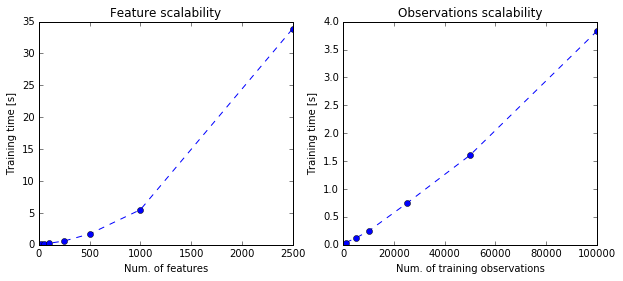

In [7]:
from sklearn.decomposition import RandomizedPCA

check_scalability(RandomizedPCA(None))

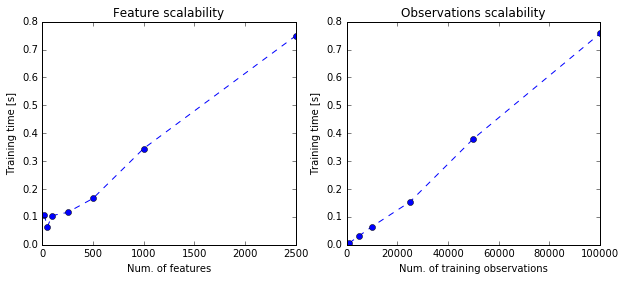

In [8]:
check_scalability(RandomizedPCA(20))

## IncrementalPCA

In [9]:
from sklearn.decomposition import IncrementalPCA

X, _ = make_blobs(100000, n_features=100, random_state=101)
pca = IncrementalPCA(None, batch_size=1000)

tik = time.time()
for i in range(100):
    pca.partial_fit(X)
print "PCA on 10M points run with constant memory usage in ", time.time() - tik, "seconds"

PCA on 10M points run with constant memory usage in  200.999202013 seconds


## SparsePCA

In [10]:
from sklearn.decomposition import MiniBatchSparsePCA

X, _ = make_blobs(25000, n_features=10000, random_state=101)

tik = time.time()
pca = MiniBatchSparsePCA(20, method='cd', random_state=101, n_iter=1000)
pca.fit(X)
print "SparsePCA on matrix", X.shape, "done in ", time.time() - tik, "seconds"

SparsePCA on matrix (25000, 10000) done in  45.0331349373 seconds


## PCA with H2O

In [11]:
import h2o
from h2o.transforms.decomposition import H2OPCA
h2o.init(max_mem_size_GB=4)

def testH2O_pca(nrows, ncols, k=20):
    temp_file = tempfile.NamedTemporaryFile().name
    X, _ = make_blobs(nrows, n_features=ncols, random_state=101)
    np.savetxt(temp_file, np.c_[X], delimiter=",")
    del X
    
    pca = H2OPCA(k=k, transform="NONE", pca_method="Power")
    tik = time.time()
    pca.train(x=range(100), training_frame=h2o.import_file(temp_file))

    print "H2OPCA on matrix ", (nrows, ncols), " done in ", time.time() - tik, "seconds"
    os.remove(temp_file)

testH2O_pca(100000, 100)
testH2O_pca(10000, 2500)
h2o.shutdown(prompt=False)



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: /var/folders/k4/z7ws54993853fnwn31bvyhmc0000gn/T/tmpVHTJBy/h2o_albertoboschetti_started_from_python.out
JVM stderr: /var/folders/k4/z7ws54993853fnwn31bvyhmc0000gn/T/tmpkB6sCN/h2o_albertoboschetti_started_from_python.err
Using ice_root: /var/folders/k4/z7ws54993853fnwn31bvyhmc0000gn/T/tmpjSwdkI


Java Version: java version "1.8.0_74"
Java(TM) SE Runtime Environment (build 1.8.0_74-b02)
Java HotSpot(TM) 64-Bit Server VM (build 25.74-b02, mixed mode)


Starting H2O JVM and connecting: ................... Connection successful!


H2O cluster uptime:,1 seconds 996 milliseconds
H2O cluster version:,3.8.2.3
H2O cluster name:,H2O_started_from_python_albertoboschetti_hli144
H2O cluster total nodes:,1
H2O cluster total free memory:,3.56 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321
H2O Connection proxy:,None



Parse Progress: [##################################################] 100%

pca Model Build Progress: [##################################################] 100%
H2OPCA on matrix  (100000, 100)  done in  14.7185230255 seconds

Parse Progress: [##################################################] 100%

pca Model Build Progress: [##################################################] 100%
H2OPCA on matrix  (10000, 2500)  done in  10.1370251179 seconds


In [12]:
# Cleanup
del X, pca
pylab.rcParams['figure.figsize'] = (6.0, 4.0)

# Clustering K-means

In [13]:
from sklearn.datasets.samples_generator import make_blobs


centers = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
X, y = make_blobs(n_samples=1000, centers=centers, 
                  cluster_std=0.5, random_state=101)

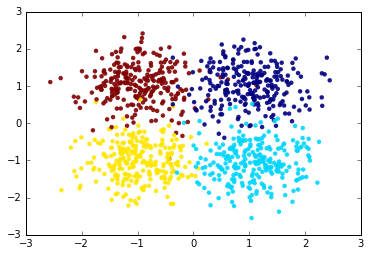

In [14]:
plt.scatter(X[:,0], X[:,1], c=y, edgecolors='none', alpha=0.9)
plt.show()

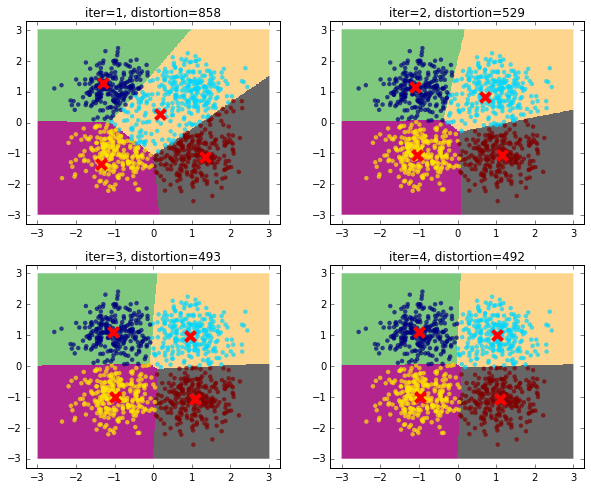

In [15]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from sklearn.cluster import KMeans

for n_iter in range(1, 5):

    cls = KMeans(n_clusters=4, max_iter=n_iter, n_init=1,
                 init='random', random_state=101)
    cls.fit(X)
    
    
    # Plot the voronoi cells
    
    plt.subplot(2, 2, n_iter)
    h=0.02
    xx, yy = np.meshgrid(np.arange(-3, 3, h), np.arange(-3, 3, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest', cmap=plt.cm.Accent,
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               aspect='auto', origin='lower')

    
    plt.scatter(X[:,0], X[:,1], c=cls.labels_, edgecolors='none', alpha=0.7)
    plt.scatter(cls.cluster_centers_[:,0], cls.cluster_centers_[:,1], 
                marker='x', color='r', s=100, linewidths=4)
    plt.title("iter=%s, distortion=%s" %(n_iter, int(cls.inertia_)))

plt.show()

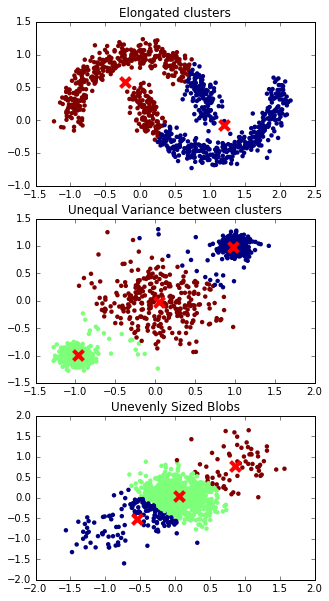

In [16]:
pylab.rcParams['figure.figsize'] = (5.0, 10.0)
from sklearn.datasets import make_moons

# Oblong/elongated sets
X, _ = make_moons(n_samples=1000, noise=0.1, random_state=101)
cls = KMeans(n_clusters=2, random_state=101)
y_pred = cls.fit_predict(X)

plt.subplot(3, 1, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, edgecolors='none')
plt.scatter(cls.cluster_centers_[:,0], cls.cluster_centers_[:,1], 
                marker='x', color='r', s=100, linewidths=4)
plt.title("Elongated clusters")

# Different variance between clusters
centers = [[-1, -1], [0, 0], [1, 1]]
X, _ = make_blobs(n_samples=1000, cluster_std=[0.1, 0.4, 0.1],
                  centers=centers, random_state=101)
cls = KMeans(n_clusters=3, random_state=101)
y_pred = cls.fit_predict(X)

plt.subplot(3, 1, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, edgecolors='none')
plt.scatter(cls.cluster_centers_[:,0], cls.cluster_centers_[:,1], 
                marker='x', color='r', s=100, linewidths=4)
plt.title("Unequal Variance between clusters")

# Unevenly sized blobs
centers = [[-1, -1], [1, 1]]
centers.extend([[0,0]]*20)
X, _ = make_blobs(n_samples=1000, centers=centers, 
                  cluster_std=0.28, random_state=101)
cls = KMeans(n_clusters=3, random_state=101)
y_pred = cls.fit_predict(X)

plt.subplot(3, 1, 3)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, edgecolors='none')
plt.scatter(cls.cluster_centers_[:,0], cls.cluster_centers_[:,1], 
                marker='x', color='r', s=100, linewidths=4)
plt.title("Unevenly Sized Blobs")

plt.show()

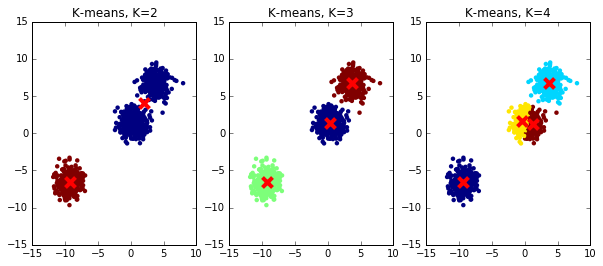

In [17]:
pylab.rcParams['figure.figsize'] = (10.0, 4.0)
X, _ = make_blobs(n_samples=1000, centers=3, random_state=101)

for K in [2, 3, 4]:
    cls = KMeans(n_clusters=K, random_state=101)
    y_pred = cls.fit_predict(X)
    
    plt.subplot(1, 3, K-1)
    plt.title("K-means, K=%s" % K)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, edgecolors='none')
    plt.scatter(cls.cluster_centers_[:,0], cls.cluster_centers_[:,1], 
                marker='x', color='r', s=100, linewidths=4)

plt.show()

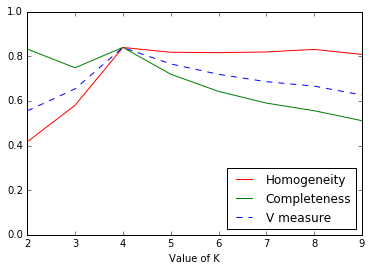

In [18]:
pylab.rcParams['figure.figsize'] = (6.0, 4.0)
from sklearn.metrics import homogeneity_completeness_v_measure


centers = [[1, 1], [1, -1], [-1, -1], [-1, 1]]
X, y = make_blobs(n_samples=1000, centers=centers, 
                  cluster_std=0.5, random_state=101)

Ks = range(2, 10)
HCVs = []
for K in Ks:
    y_pred = KMeans(n_clusters=K, random_state=101).fit_predict(X)
    HCVs.append(homogeneity_completeness_v_measure(y, y_pred))

plt.plot(Ks, [el[0] for el in HCVs], 'r', label='Homogeneity')
plt.plot(Ks, [el[1] for el in HCVs], 'g', label='Completeness')
plt.plot(Ks, [el[2] for el in HCVs], 'b--', label='V measure')
plt.ylim([0, 1])
plt.xlabel("Value of K")
plt.legend(loc=4)
plt.show()

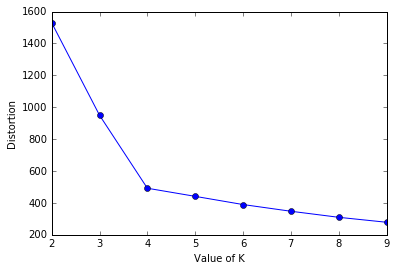

In [19]:
Ks = range(2, 10)
Ds = []
for K in Ks:
    cls = KMeans(n_clusters=K, random_state=101)
    cls.fit(X)
    Ds.append(cls.inertia_)

plt.plot(Ks, Ds, 'o-')
plt.xlabel("Value of K")
plt.ylabel("Distortion")
plt.show()

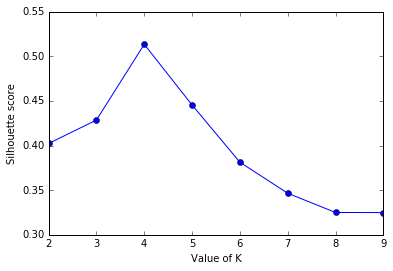

In [20]:
from sklearn.metrics import silhouette_score

Ks = range(2, 10)
Ds = []
for K in Ks:
    cls = KMeans(n_clusters=K, random_state=101)
    Ds.append(silhouette_score(X, cls.fit_predict(X)))

plt.plot(Ks, Ds, 'o-')
plt.xlabel("Value of K")
plt.ylabel("Silhouette score")
plt.show()

## Batch K-means

In [21]:
import urllib
import os.path

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990.data.txt"
census_csv_file = "./USCensus1990.data.txt"

import os.path
if not os.path.exists(census_csv_file):
    testfile = urllib.URLopener()
    testfile.retrieve(url, census_csv_file)
if not os.path.exists(census_csv_file):
    testfile = urllib.URLopener()
    testfile.retrieve(url, census_csv_file)

Dataset size: 20000
K: 4
1 loop, best of 1: 456 ms per loop
K: 8
1 loop, best of 1: 1.17 s per loop
K: 12
1 loop, best of 1: 1.64 s per loop
Dataset size: 200000
K: 4
1 loop, best of 1: 5.49 s per loop
K: 8
1 loop, best of 1: 8.86 s per loop
K: 12
1 loop, best of 1: 15.3 s per loop
Dataset size: 500000
K: 4
1 loop, best of 1: 11 s per loop
K: 8
1 loop, best of 1: 39.9 s per loop
K: 12
1 loop, best of 1: 56.6 s per loop


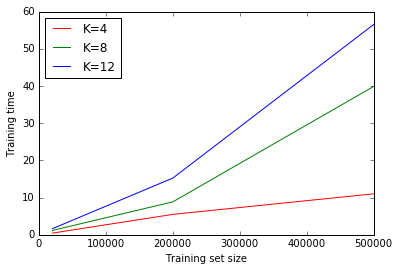

In [22]:
piece_of_dataset = pd.read_csv(census_csv_file, iterator=True).get_chunk(500000).drop('caseid', axis=1).as_matrix()

time_results = {4: [], 8:[], 12:[]}
dataset_sizes = [20000, 200000, 500000]


for dataset_size in dataset_sizes:
    print "Dataset size:", dataset_size
    X = piece_of_dataset[:dataset_size,:]
        
    for K in [4, 8, 12]:
        print "K:", K
        cls = KMeans(K, random_state=101)
        timeit = %timeit -o -n1 -r1 cls.fit(X)

        time_results[K].append(timeit.best)

plt.plot(dataset_sizes, time_results[4], 'r', label='K=4')
plt.plot(dataset_sizes, time_results[8], 'g', label='K=8')
plt.plot(dataset_sizes, time_results[12], 'b', label='K=12')

plt.xlabel("Training set size")
plt.ylabel("Training time")
plt.legend(loc=0)
plt.show()


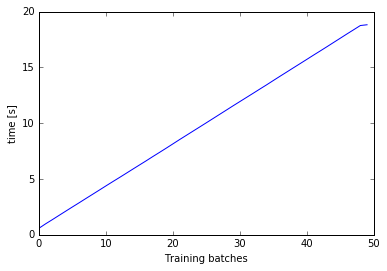

In [23]:
from sklearn.cluster import MiniBatchKMeans
import time

cls = MiniBatchKMeans(12, batch_size=1000, random_state=101)
ts = []

tik = time.time()
for chunk in pd.read_csv(census_csv_file, chunksize=50000):
    cls.partial_fit(chunk.drop('caseid', axis=1))
    ts.append(time.time()-tik)
        
plt.plot(range(len(ts)), ts)
plt.xlabel('Training batches')
plt.ylabel('time [s]')

plt.show()

K= 4
K= 5
K= 6
K= 7
K= 8
K= 9
K= 10
K= 11
K= 12


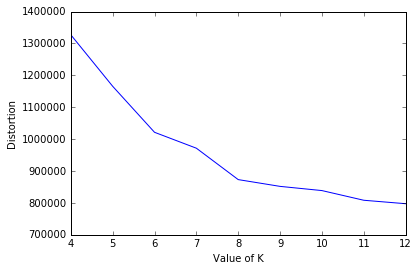

In [24]:
Ks = list(range(4, 13))
ds = []

for K in Ks:
    print "K=", K
    cls = MiniBatchKMeans(K, batch_size=1000, random_state=101)

    for chunk in pd.read_csv(census_csv_file, chunksize=50000):
        cls.partial_fit(chunk.drop('caseid', axis=1))
    ds.append(cls.inertia_)

plt.plot(Ks, ds)
plt.xlabel('Value of K')
plt.ylabel('Distortion')

plt.show()

## K-means with H2O



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: /var/folders/k4/z7ws54993853fnwn31bvyhmc0000gn/T/tmpGbnTi4/h2o_albertoboschetti_started_from_python.out
JVM stderr: /var/folders/k4/z7ws54993853fnwn31bvyhmc0000gn/T/tmp4njrzg/h2o_albertoboschetti_started_from_python.err
Using ice_root: /var/folders/k4/z7ws54993853fnwn31bvyhmc0000gn/T/tmpOkD7r7


Java Version: java version "1.8.0_74"
Java(TM) SE Runtime Environment (build 1.8.0_74-b02)
Java HotSpot(TM) 64-Bit Server VM (build 25.74-b02, mixed mode)


Starting H2O JVM and connecting: ............... Connection successful!


H2O cluster uptime:,1 seconds 772 milliseconds
H2O cluster version:,3.8.2.3
H2O cluster name:,H2O_started_from_python_albertoboschetti_psl007
H2O cluster total nodes:,1
H2O cluster total free memory:,3.56 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321
H2O Connection proxy:,None


Dataset size: 20000
K: 4

Parse Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%
K: 8

Parse Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%
K: 12

Parse Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%
Dataset size: 200000
K: 4

Parse Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%
K: 8

Parse Progress: [##################################################] 100%

kmeans Model Build Progress: [##################################################] 100%
K: 12

Parse Progress: [##################################################] 100%

kmeans Model Build Progress: [######

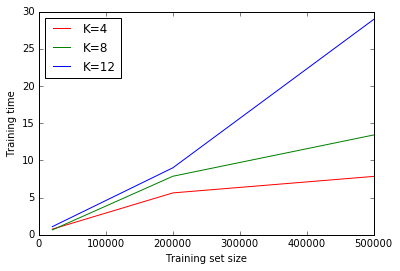


Parse Progress: [##################################################] 100%


In [25]:
import h2o
from h2o.estimators.kmeans import H2OKMeansEstimator
h2o.init(max_mem_size_GB=4)

def testH2O_kmeans(X, k):
    
    temp_file = tempfile.NamedTemporaryFile().name
    np.savetxt(temp_file, np.c_[X], delimiter=",")
    
    cls = H2OKMeansEstimator(k=k, standardize=True)
    blobdata = h2o.import_file(temp_file) 
    
    tik = time.time()
    cls.train(x=range(blobdata.ncol), training_frame=blobdata)
    fit_time = time.time() - tik

    os.remove(temp_file)
    
    return fit_time


piece_of_dataset = pd.read_csv(census_csv_file, iterator=True).get_chunk(500000).drop('caseid', axis=1).as_matrix()
time_results = {4: [], 8:[], 12:[]}
dataset_sizes = [20000, 200000, 500000]


for dataset_size in dataset_sizes:
    print "Dataset size:", dataset_size
    X = piece_of_dataset[:dataset_size,:]
        
    for K in [4, 8, 12]:
        print "K:", K
        fit_time = testH2O_kmeans(X, K)
        time_results[K].append(fit_time)

plt.plot(dataset_sizes, time_results[4], 'r', label='K=4')
plt.plot(dataset_sizes, time_results[8], 'g', label='K=8')
plt.plot(dataset_sizes, time_results[12], 'b', label='K=12')

plt.xlabel("Training set size")
plt.ylabel("Training time")
plt.legend(loc=0)
plt.show()


testH2O_kmeans(100000, 100)

h2o.shutdown(prompt=False)

In [26]:
del X, y, Z, chunk, cls, piece_of_dataset, xx, yy, y_pred

# LDA

In [27]:
from sklearn.datasets import fetch_20newsgroups
documents = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), random_state=101).data

In [28]:
len(documents)

11314

In [29]:
document_num = 9960
print documents[document_num]

Help!!!

I have an ADB graphicsd tablet which I want to connect to my
Quadra 950. Unfortunately, the 950 has only one ADB port and
it seems I would have to give up my mouse.

Please, can someone help me? I want to use the tablet as well as
the mouse (and the keyboard of course!!!).

Thanks in advance.


In [30]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

np.random.seed(101)

In [31]:
lm = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def lem_stem(text):
    return stemmer.stem(lm.lemmatize(text, pos='v'))

def tokenize_lemmatize(text):
    return [lem_stem(token)
            for token in gensim.utils.simple_preprocess(text) 
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3]

print tokenize_lemmatize(documents[document_num])

[u'help', u'graphicsd', u'tablet', u'want', u'connect', u'quadra', u'unfortun', u'port', u'mous', u'help', u'want', u'tablet', u'mous', u'keyboard', u'cours', u'thank', u'advanc']


In [32]:
processed_docs = [tokenize_lemmatize(doc) for doc in documents]
word_count_dict = gensim.corpora.Dictionary(processed_docs)

In [33]:
# word must appear >20 times, and no more than 20% documents

word_count_dict.filter_extremes(no_below=20, no_above=0.2)

In [34]:
bag_of_words_corpus = [word_count_dict.doc2bow(pdoc) for pdoc in processed_docs]

In [35]:
bow_doc1 = bag_of_words_corpus[document_num]

for i in range(len(bow_doc1)):
    print "Word {} (\"{}\") appears {} time[s]".format(bow_doc1[i][0], word_count_dict[bow_doc1[i][0]], bow_doc1[i][1])


Word 178 ("want") appears 2 time[s]
Word 250 ("keyboard") appears 1 time[s]
Word 833 ("unfortun") appears 1 time[s]
Word 1037 ("port") appears 1 time[s]
Word 1142 ("help") appears 2 time[s]
Word 1543 ("quadra") appears 1 time[s]
Word 2006 ("advanc") appears 1 time[s]
Word 2124 ("cours") appears 1 time[s]
Word 2391 ("thank") appears 1 time[s]
Word 2898 ("mous") appears 2 time[s]
Word 3313 ("connect") appears 1 time[s]


In [36]:
# LDA mono-core
lda_model = gensim.models.LdaModel(bag_of_words_corpus, num_topics=12, id2word=word_count_dict, iterations=200, passes=50)

# LDA multicore (in this configuration, defaulty, uses n_cores-1)
# lda_model = gensim.models.LdaMulticore(bag_of_words_corpus, num_topics=12, id2word=word_count_dict, passes=50, workers=4)

In [37]:
for idx, topic in lda_model.print_topics(-1):
    print "Topic:{} Word composition:{}".format(idx, topic)
    print

Topic:0 Word composition:0.015*imag + 0.014*version + 0.013*avail + 0.013*includ + 0.013*softwar + 0.012*file + 0.011*graphic + 0.010*program + 0.010*data + 0.009*format

Topic:1 Word composition:0.040*window + 0.030*file + 0.018*program + 0.014*problem + 0.011*widget + 0.011*applic + 0.010*server + 0.010*entri + 0.009*display + 0.009*error

Topic:2 Word composition:0.011*peopl + 0.010*mean + 0.010*question + 0.009*believ + 0.009*exist + 0.008*encrypt + 0.008*point + 0.008*reason + 0.008*post + 0.007*thing

Topic:3 Word composition:0.010*caus + 0.009*good + 0.009*test + 0.009*bike + 0.008*problem + 0.008*effect + 0.008*differ + 0.008*engin + 0.007*time + 0.006*high

Topic:4 Word composition:0.018*state + 0.017*govern + 0.015*right + 0.010*weapon + 0.010*crime + 0.009*peopl + 0.009*protect + 0.008*legal + 0.008*control + 0.008*drug

Topic:5 Word composition:0.017*christian + 0.016*armenian + 0.013*jesus + 0.012*peopl + 0.008*say + 0.008*church + 0.007*bibl + 0.007*come + 0.006*live + 0.

In [38]:
for index, score in sorted(lda_model[bag_of_words_corpus[document_num]], key=lambda tup: -1*tup[1]):
    print "Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 10))

Score: 0.938887758964	 Topic: 0.022*thank + 0.020*card + 0.015*work + 0.013*need + 0.013*price + 0.012*driver + 0.010*sell + 0.010*help + 0.010*mail + 0.010*look


In [39]:
print "Log perplexity of the model is", lda_model.log_perplexity(bag_of_words_corpus)

Log perplexity of the model is -7.2985188569


In [40]:
unseen_document = "Golf or tennis? Which is the best sport to play?"

bow_vector = word_count_dict.doc2bow(tokenize_lemmatize(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print "Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5))

Score: 0.610691655136	 Topic: 0.044*game + 0.031*team + 0.027*play + 0.022*year + 0.020*player
Score: 0.222640440339	 Topic: 0.018*state + 0.017*govern + 0.015*right + 0.010*weapon + 0.010*crime
Score: 0.0166673079513	 Topic: 0.018*go + 0.015*time + 0.013*say + 0.012*peopl + 0.012*come
Score: 0.0166669083674	 Topic: 0.022*thank + 0.020*card + 0.015*work + 0.013*need + 0.013*price
Score: 0.0166668118675	 Topic: 0.010*caus + 0.009*good + 0.009*test + 0.009*bike + 0.008*problem
Score: 0.0166667533704	 Topic: 0.011*peopl + 0.010*mean + 0.010*question + 0.009*believ + 0.009*exist
Score: 0.0166667357917	 Topic: 0.015*imag + 0.014*version + 0.013*avail + 0.013*includ + 0.013*softwar
Score: 0.0166666944919	 Topic: 0.040*window + 0.030*file + 0.018*program + 0.014*problem + 0.011*widget
Score: 0.01666668531	 Topic: 0.017*christian + 0.016*armenian + 0.013*jesus + 0.012*peopl + 0.008*say
Score: 0.0166666740412	 Topic: 0.012*presid + 0.009*state + 0.008*peopl + 0.008*work + 0.008*govern
Score: 0.

In [41]:
small_corpus = bag_of_words_corpus[:1000]
batch_times = {}

for batch_size in [50, 100, 200, 500]:
    print "batch_size =", batch_size
    tik0 = time.time()
    lda_model = gensim.models.LdaModel(num_topics=12, id2word=word_count_dict)
    batch_times[batch_size] = []
    
    for i in range(0, len(small_corpus), batch_size):
        lda_model.update(small_corpus[i:i+batch_size], update_every=25, passes=1+500/batch_size)
        batch_times[batch_size].append(time.time() - tik0)

batch_size = 50
batch_size = 100
batch_size = 200
batch_size = 500


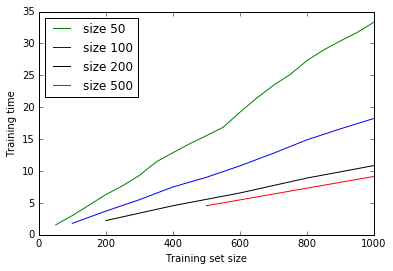

In [42]:
plt.plot(range(50, 1001, 50), batch_times[50], 'g', label='size 50')
plt.plot(range(100, 1001, 100), batch_times[100], 'b', label='size 100')
plt.plot(range(200, 1001, 200), batch_times[200], 'k', label='size 200')
plt.plot(range(500, 1001, 500), batch_times[500], 'r', label='size 500')

plt.xlabel("Training set size")
plt.ylabel("Training time")
plt.xlim([0, 1000])
plt.legend(loc=0)
plt.show()